In [1]:
# Standard Libraries
import os
import math
import random
from datetime import datetime
from collections import Counter

# Data Handling and Visualization
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Data Preprocessing
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, recall_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import joblib

# Additional Libraries
import community as community_louvain  # For community detection in networks
from scipy import stats
from tqdm import tqdm
import itertools


In [15]:
import importlib
import functions  
importlib.reload(functions)  

<module 'functions' from '/Users/michaelfeduk/Desktop/projects/Facebook_project/functions.py'>

## Data Pre Processing

In [3]:
G = nx.read_edgelist('facebook_combined.txt', delimiter=' ', nodetype=int)

test_dict = functions.test_split(G)

In [4]:
G_test = test_dict['graph']
test_edges = test_dict['x_edges']

In [17]:
G_test = test_dict['graph']
test_edges = test_dict['x_edges']

cross_val_list = functions.validation_train_split(G_test, 9)

df_train_val_test_dict = functions.distribute_non_edges(G,G_test,test_edges,cross_val_list)

In [19]:
df_list = df_train_val_test_dict['train_val_df_list']

df_test = df_train_val_test_dict['df_test']

functions.add_features_to_df(df_test,G_test)
df_test = functions.scale_features(df_test)

for i, item in enumerate(df_list):
    df = item['df']
    graph = item['graph']
    
    functions.add_features_to_df(df, graph)
    df = functions.scale_features(df)
    df_list[i] = df


#### Class imbalance

In [20]:
sum_pos = df_test[df_test['label'] == 1].shape[0]
sum_neg = df_test[df_test['label'] == 0].shape[0]
for df in df_list:
    df_pos = df[df['label'] == 1].shape[0]  
    df_neg = df[df['label'] == 0].shape[0]  
    sum_pos += df_pos
    sum_neg += df_neg

print(f"Total positives (1s): {sum_pos}")
print(f"Total negatives (0s): {sum_neg}")
print(f"Percentage of positive samples: {sum_pos/(sum_pos+sum_neg)}")

Total positives (1s): 87655
Total negatives (0s): 1008475
Percentage of positive samples: 0.07996770456059044


## Data Exploration 

### Correlations

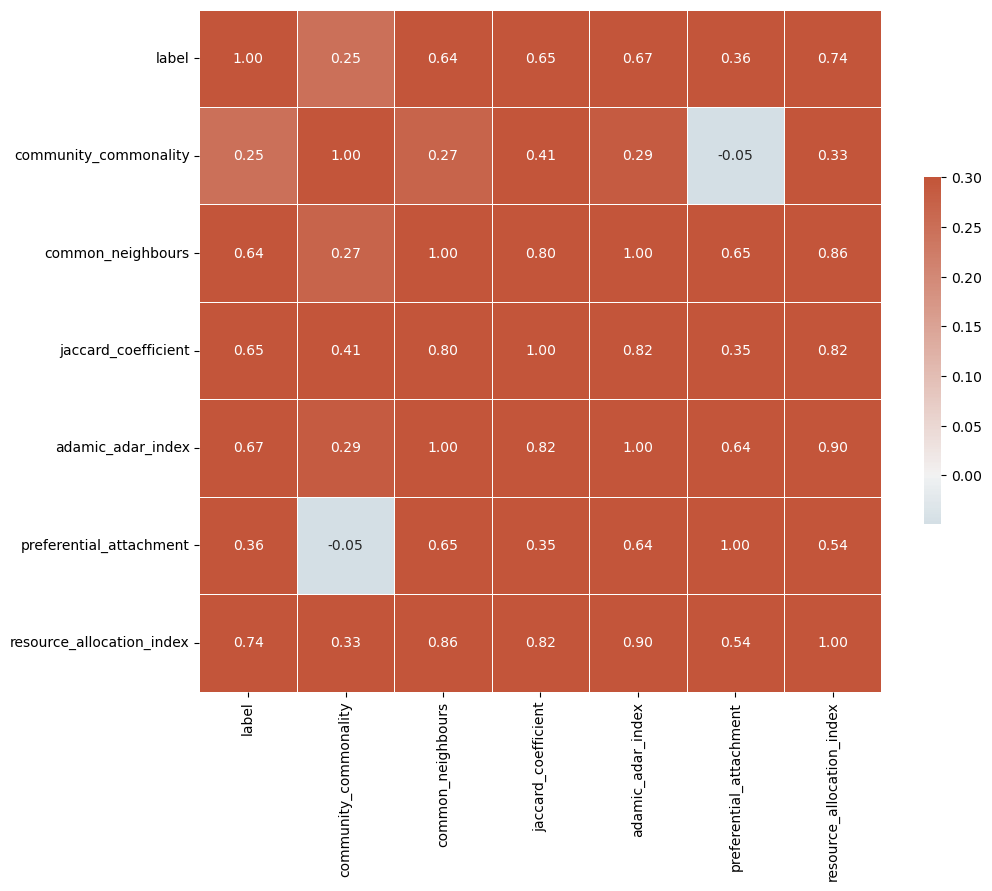

In [21]:

combined_train_df = pd.concat(df_list, ignore_index=True)

correlation_matrix = combined_train_df.drop(columns=['node1', 'node2']).corr()

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(correlation_matrix, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

plt.show()




## Baseline: features and models

### Individual features

In [22]:

features = [
    'community_commonality', 'common_neighbours', 'jaccard_coefficient',
    'adamic_adar_index', 'preferential_attachment', 'resource_allocation_index'
]

recall_scores = {}

for feature in features:

    fold_true_positives = []
    
    for i, val_df in enumerate(df_list):

        actual_positives = val_df[val_df['label'] == 1].shape[0]
        
        top_n_predictions = val_df.nlargest(actual_positives, feature)
        
        true_positives = top_n_predictions['label'].sum()

        fold_true_positives.append(true_positives)
    
    total_true_positives = sum(fold_true_positives)
    total_actual_positives = sum([df[df['label'] == 1].shape[0] for df in df_list])
    
    recall = total_true_positives / total_actual_positives
    recall_scores[feature] = recall

for feature, score in sorted(recall_scores.items(), key=lambda item: item[1], reverse=True):
    print(f"Recall for {feature}: {score:.4f}")


Recall for resource_allocation_index: 0.7302
Recall for adamic_adar_index: 0.6575
Recall for jaccard_coefficient: 0.6566
Recall for common_neighbours: 0.6311
Recall for preferential_attachment: 0.3887
Recall for community_commonality: 0.1431


## Cross Validation

In [23]:
baseline_results = {}

### Random Forrest

random forrest is super slow

In [24]:
rf_model = RandomForestClassifier(random_state=42)

feature_cols = [
    'community_commonality', 'common_neighbours',
    'jaccard_coefficient', 'adamic_adar_index', 'preferential_attachment',
    'resource_allocation_index'
]

baseline_results['Random Forest'] = functions.cross_validate(rf_model, df_list, feature_cols, verbosity=1)

print(f"Recall score: {baseline_results['Random Forest']['recall']}")


Fold 1 / 9 done
Fold 2 / 9 done
Fold 3 / 9 done
Fold 4 / 9 done
Fold 5 / 9 done
Fold 6 / 9 done
Fold 7 / 9 done
Fold 8 / 9 done
Fold 9 / 9 done
Recall score: 0.7330779378932413


### XGBoost

In [25]:
feature_cols = [
    'community_commonality', 'common_neighbours',
    'jaccard_coefficient', 'adamic_adar_index', 'preferential_attachment',
    'resource_allocation_index'
]

xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

baseline_results['XGBoost'] = functions.cross_validate(xgb_classifier, df_list, feature_cols, verbosity=1)

print(f"Recall score: {baseline_results['XGBoost']['recall']}")


Fold 1 / 9 done
Fold 2 / 9 done
Fold 3 / 9 done
Fold 4 / 9 done
Fold 5 / 9 done
Fold 6 / 9 done
Fold 7 / 9 done
Fold 8 / 9 done
Fold 9 / 9 done
Recall score: 0.7443423990257764


### K-Nearest Neighbours (KNN):

In [27]:

knn_classifier = KNeighborsClassifier(n_neighbors=5)

baseline_results['KNN'] = functions.cross_validate(knn_classifier, df_list, feature_cols, verbosity=1)

print(f"Recall score: {baseline_results['KNN'] ['recall']}")

Fold 1 / 9 done
Fold 2 / 9 done
Fold 3 / 9 done
Fold 4 / 9 done
Fold 5 / 9 done
Fold 6 / 9 done
Fold 7 / 9 done
Fold 8 / 9 done
Fold 9 / 9 done
Recall score: 0.707162066166024


### Logistic Regression

In [28]:
logreg_classifier = LogisticRegression(max_iter=10000)  # Increasing max_iter might be necessary for convergence

baseline_results['Logistic Regression']  = functions.cross_validate(logreg_classifier, df_list, feature_cols, verbosity=1)

print(f"Recall score: {baseline_results['Logistic Regression']['recall']}")

Fold 1 / 9 done
Fold 2 / 9 done
Fold 3 / 9 done
Fold 4 / 9 done
Fold 5 / 9 done
Fold 6 / 9 done
Fold 7 / 9 done
Fold 8 / 9 done
Fold 9 / 9 done
Recall score: 0.7338390501319261


### LightGBM

In [ ]:
lgbm_classifier = lgb.LGBMClassifier(
    objective='binary',  
    num_leaves=31,       
    learning_rate=0.05,  
    n_estimators=100     
)

baseline_results['LightGBM'] = functions.cross_validate(lgbm_classifier, df_list, feature_cols, verbosity=1)

print(f"Recall score: {baseline_results['LightGBM']['recall']}")

### CatBoost

In [30]:

catboost_classifier = CatBoostClassifier(
    iterations=100,      
    learning_rate=0.1,   
    depth=6,             
    verbose=False        
)

baseline_results['CatBoost'] = functions.cross_validate(catboost_classifier, df_list, feature_cols, verbosity=1)

print(f"Recall score: {baseline_results['CatBoost']['recall']}")


Fold 1 / 9 done
Fold 2 / 9 done
Fold 3 / 9 done
Fold 4 / 9 done
Fold 5 / 9 done
Fold 6 / 9 done
Fold 7 / 9 done
Fold 8 / 9 done
Fold 9 / 9 done
Recall score: 0.7400928556931196


### AdaBoost

In [31]:

adaboost_classifier = AdaBoostClassifier(
    n_estimators=50,     
    learning_rate=1.0
)

baseline_results['AdaBoost'] = functions.cross_validate(adaboost_classifier, df_list, feature_cols, verbosity=1)

print(f"Recall score: {baseline_results['AdaBoost']['recall']}")

Fold 1 / 9 done
Fold 2 / 9 done
Fold 3 / 9 done
Fold 4 / 9 done
Fold 5 / 9 done
Fold 6 / 9 done
Fold 7 / 9 done
Fold 8 / 9 done
Fold 9 / 9 done
Recall score: 0.7318982139232799


### Stochastic Gradient Descent (SGD) Classifier

In [32]:

sgd_classifier = SGDClassifier(
    loss='log_loss',          
    max_iter=1000,       
    tol=1e-3,            
    learning_rate='optimal',  
    early_stopping=True
)

baseline_results['SDGClassifier'] = functions.cross_validate(sgd_classifier, df_list, feature_cols, verbosity=1)

print(f"Recall score: {baseline_results['SDGClassifier']['recall']}")


Fold 1 / 9 done
Fold 2 / 9 done
Fold 3 / 9 done
Fold 4 / 9 done
Fold 5 / 9 done
Fold 6 / 9 done
Fold 7 / 9 done
Fold 8 / 9 done
Fold 9 / 9 done
Recall score: 0.6693221026994114


### Results table 


In [33]:
model_recall_pairs = []

for model_name, metrics in baseline_results.items():
    recall_score = metrics['recall']
    model_recall_pairs.append((model_name, recall_score))

df_recall_scores = pd.DataFrame(model_recall_pairs, columns=['Model', 'Recall'])
df_recall_scores.sort_values(by='Recall', ascending=False, inplace=True)
df_recall_scores.reset_index(drop=True, inplace=True)

print(df_recall_scores)

                 Model    Recall
0              XGBoost  0.744342
1             LightGBM  0.741501
2             CatBoost  0.740093
3  Logistic Regression  0.733839
4        Random Forest  0.733078
5             AdaBoost  0.731898
6                  KNN  0.707162
7        SDGClassifier  0.669322


## GridSearch CV

In [34]:
grid_search_cv = {}

#### XGBoost

In [35]:
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'n_estimators': [100, 200, 500],  
    'max_depth': [3, 4, 5, 6], 
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

xgb_combinations = functions.expand_grid(param_grid_xgb)

xgb_combinations['n_estimators'] = xgb_combinations['n_estimators'].astype(int)
xgb_combinations['max_depth'] = xgb_combinations['max_depth'].astype(int)


grid_search_cv['XGBoost'] = functions.GridSearchCV(xgb_combinations, xgb.XGBClassifier, df_list, feature_cols)

#### K-Nearest Neighbours (KNN)

In [36]:
param_grid_knn = {
    'n_neighbors': [5, 7, 9, 11, 13, 15, 17, 21, 23],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]
}
all_combinations = functions.expand_grid(param_grid_knn)

knn_combinations = all_combinations.copy()
knn_combinations = knn_combinations[knn_combinations['metric'] == 'minkowski']
non_minkowski_combinations = all_combinations[all_combinations['metric'] != 'minkowski'].drop('p', axis=1)
non_minkowski_combinations = non_minkowski_combinations.drop_duplicates()
knn_combinations = pd.concat([knn_combinations, non_minkowski_combinations], ignore_index=True)

grid_search_cv['KNN'] = functions.GridSearchCV(knn_combinations, KNeighborsClassifier, df_list, feature_cols)

#### Logistic Regression

In [ ]:
param_grid_logistic = {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': [100, 200, 500],
        'l1_ratio': [0.2, 0.5, 0.8] 
    }

all_combinations = functions.expand_grid(param_grid_logistic)

# For 'newton-cg', 'lbfgs', 'sag' - only 'l2' and 'none'
newton_lbfgs_sag_combinations = all_combinations[all_combinations['solver'].isin(['newton-cg', 'lbfgs', 'sag']) & all_combinations['penalty'].isin(['l2', 'none'])]

# For 'liblinear' - 'l1' and 'l2' (excluding 'none' and 'elasticnet')
liblinear_combinations = all_combinations[(all_combinations['solver'] == 'liblinear') & (all_combinations['penalty'].isin(['l1', 'l2']))]

# For 'saga' - all penalties are valid
saga_combinations = all_combinations[all_combinations['solver'] == 'saga']

# Concatenate all valid combinations
logreg_combinations = pd.concat([newton_lbfgs_sag_combinations, liblinear_combinations, saga_combinations], ignore_index=True)

# Set l1_ratio to NaN for rows where solver is not 'saga' or penalty is not 'elasticnet'
logreg_combinations.loc[~((logreg_combinations['solver'] == 'saga') & (logreg_combinations['penalty'] == 'elasticnet')), 'l1_ratio'] = np.nan

logreg_combinations = logreg_combinations.drop_duplicates()

grid_search_cv['Logistic Regression'] = functions.GridSearchCV(logreg_combinations, LogisticRegression, df_list, feature_cols)


#### Light GBM

In [ ]:
param_grid_lgbm = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'num_leaves': [31, 50, 100],
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'subsample': [0.5, 0.7, 1.0]
}

lgbm_combinations = functions.expand_grid(param_grid_lgbm)

# Filter out 'subsample' for 'goss' boosting type
lgbm_combinations = lgbm_combinations[~((lgbm_combinations['boosting_type'] == 'goss') & (lgbm_combinations['subsample'] != 1.0))]

grid_search_cv['LightGBM'] = functions.GridSearchCV(lgbm_combinations, lgb.LGBMClassifier, df_list, feature_cols)


#### CatBoost

In [ ]:
param_grid_catboost = {
    'iterations': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.5],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

catboost_combinations = functions.expand_grid(param_grid_catboost)

grid_search_cv['CatBoost'] = functions.GridSearchCV(catboost_combinations, CatBoostClassifier, df_list, feature_cols)


#### AdaBoost

In [40]:
param_grid_adaboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

adaboost_combinations = functions.expand_grid(param_grid_adaboost)

grid_search_cv['AdaBoost'] = functions.GridSearchCV(adaboost_combinations, AdaBoostClassifier, df_list, feature_cols)

#### Stochastic Gradient Descent (SGD) Classifier

In [41]:
param_grid_sgd = {
    'loss': ['log_loss', 'modified_huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.01, 0.1, 1]  
}

all_combinations = functions.expand_grid(param_grid_sgd)

# Remove 'eta0' from 'optimal' combinations and add non-'eta0' combinations
sgd_combinations = all_combinations.copy()
eta_combinations = sgd_combinations[sgd_combinations['learning_rate'].isin(['constant', 'invscaling','adaptive'])]
non_eta_combinations = sgd_combinations[sgd_combinations['learning_rate']=='optimal']
non_eta_combinations = non_eta_combinations.drop('eta0', axis=1).drop_duplicates()

sgd_combinations = pd.concat([eta_combinations, non_eta_combinations], ignore_index=True)

grid_search_cv['SGD Classifier'] = functions.GridSearchCV(sgd_combinations, SGDClassifier, df_list, feature_cols)


#### GridSearchCV Table

In [52]:
highest_recall_scores = []

for model_name, df in grid_search_cv.items():
    top_recall = df.sort_values(by='recall', ascending=False).iloc[0]['recall']
    highest_recall_scores.append((model_name, top_recall))

df_grid_search_recall = pd.DataFrame(highest_recall_scores, columns=['Model', 'Highest Recall']).sort_values(by="Highest Recall", ascending=False)

print(df_grid_search_recall.reset_index(drop=True))

                 Model  Highest Recall
0             CatBoost        0.745865
1              XGBoost        0.745154
2             LightGBM        0.745015
3                  KNN        0.735957
4             AdaBoost        0.735793
5       SGD Classifier        0.735349
6  Logistic Regression        0.734156


## Ensemble models

In [43]:
for model_name, df in grid_search_cv.items():
    grid_search_cv[model_name] = df.sort_values(by='recall', ascending=False)

In [ ]:

best_catboost_params = functions.convert_to_int(functions.remove_recall_and_nan(grid_search_cv['CatBoost'].iloc[0].to_dict()))
best_xgboost_params = functions.convert_to_int(functions.remove_recall_and_nan(grid_search_cv['XGBoost'].iloc[0].to_dict()))
best_lightgbm_params = functions.convert_to_int(functions.remove_recall_and_nan(grid_search_cv['LightGBM'].iloc[0].to_dict()))
best_sgd_params = functions.convert_to_int(functions.remove_recall_and_nan(grid_search_cv['SGD Classifier'].iloc[0].to_dict()))
best_logreg_params = functions.convert_to_int(functions.remove_recall_and_nan(grid_search_cv['Logistic Regression'].iloc[0].to_dict()))



catboost_model = CatBoostClassifier(**best_catboost_params)
xgboost_model = XGBClassifier(**best_xgboost_params)
lightgbm_model = LGBMClassifier(**best_lightgbm_params)
sgd_model = SGDClassifier(**best_sgd_params)
logreg_model = LogisticRegression(**best_logreg_params)

top_ensemble = [catboost_model, xgboost_model, lightgbm_model]
diverse_ensemble = [catboost_model, xgboost_model, lightgbm_model, sgd_model, logreg_model]

top_ensemble_mult = functions.cross_validate_ensemble(top_ensemble, df_list, feature_cols,  multiply = True, verbosity=1)
top_ensemble_add = functions.cross_validate_ensemble(top_ensemble, df_list, feature_cols,  multiply = False, verbosity=1)
diverse_ensemble_mult = functions.cross_validate_ensemble(diverse_ensemble, df_list, feature_cols,  multiply = True, verbosity=1)
diverse_ensemble_add = functions.cross_validate_ensemble(diverse_ensemble, df_list, feature_cols,  multiply = False, verbosity=1)




In [45]:

print("Top ensemble:")
print("Multiplied probability recall: ",top_ensemble_mult['recall'])
print("Summed probability recall: ",top_ensemble_add['recall'])
print("____________________")
print("Diverse ensemble:")
print("Multiplied probability recall: ",diverse_ensemble_mult['recall'])
print("Summed probability recall: ",diverse_ensemble_add['recall'])

Top ensemble:
Multiplied probability recall:  0.746359346458291
Summed probability recall:  0.7465369393139841
____________________
Diverse ensemble:
Multiplied probability recall:  0.7430358230160341
Summed probability recall:  0.744608788309316


## Testing

### Single Features

In [46]:
features = [
    'community_commonality', 'common_neighbours', 'jaccard_coefficient',
    'adamic_adar_index', 'preferential_attachment', 'resource_allocation_index'
]

recall_scores = {}

for feature in features:
    total_true_positives = []
    
    actual_positives = df_test[df_test['label'] == 1].shape[0]
    
    top_n_predictions = df_test.nlargest(actual_positives, feature)
    
    true_positives = top_n_predictions['label'].sum()
    
    total_true_positives.append(true_positives)
    
    total_true_positives = sum(total_true_positives)
    total_actual_positives = df_test[df_test['label'] == 1].shape[0]

    
    recall = total_true_positives / total_actual_positives
    recall_scores[feature] = recall

for feature, score in sorted(recall_scores.items(), key=lambda item: item[1], reverse=True):
    print(f"Recall for {feature}: {score:.4f}")

Recall for resource_allocation_index: 0.7358
Recall for jaccard_coefficient: 0.6663
Recall for adamic_adar_index: 0.6584
Recall for common_neighbours: 0.6314
Recall for preferential_attachment: 0.3827
Recall for community_commonality: 0.1268


### Single Models

In [47]:
best_catboost_params = functions.convert_to_int(functions.remove_recall_and_nan(grid_search_cv['CatBoost'].iloc[0].to_dict()))
best_xgboost_params = functions.convert_to_int(functions.remove_recall_and_nan(grid_search_cv['XGBoost'].iloc[0].to_dict()))
best_lightgbm_params = functions.convert_to_int(functions.remove_recall_and_nan(grid_search_cv['LightGBM'].iloc[0].to_dict()))
best_sgd_params = functions.convert_to_int(functions.remove_recall_and_nan(grid_search_cv['SGD Classifier'].iloc[0].to_dict()))
best_logreg_params = functions.convert_to_int(functions.remove_recall_and_nan(grid_search_cv['Logistic Regression'].iloc[0].to_dict()))
best_adaboost_params = functions.convert_to_int(functions.remove_recall_and_nan(grid_search_cv['AdaBoost'].iloc[0].to_dict()))
best_knn_params = functions.convert_to_int(functions.remove_recall_and_nan(grid_search_cv['KNN'].iloc[0].to_dict()))



catboost_model = CatBoostClassifier(**best_catboost_params)
xgboost_model = XGBClassifier(**best_xgboost_params)
lightgbm_model = LGBMClassifier(**best_lightgbm_params)
sgd_model = SGDClassifier(**best_sgd_params)
logreg_model = LogisticRegression(**best_logreg_params)
adaboost_model = AdaBoostClassifier(**best_adaboost_params)
knn_model = KNeighborsClassifier(**best_knn_params)


In [ ]:

models_dict = {
    'CatBoost': catboost_model, 
    'XGBoost': xgboost_model, 
    'LightGBM': lightgbm_model, 
    'SGD': sgd_model, 
    'Logistic Regression': logreg_model, 
    'AdaBoost': adaboost_model, 
    'KNN': knn_model
}


model_names = []
recall_scores = []


for model_name, model in models_dict.items():
    recall = functions.test(df_test, df_list, model, feature_cols)['recall']
    model_names.append(model_name)
    recall_scores.append(recall)


results_df = pd.DataFrame({'Model': model_names, 'Recall': recall_scores})
sorted_results_df = results_df.sort_values(by='Recall', ascending=False)

In [49]:
print(sorted_results_df)

                 Model    Recall
1              XGBoost  0.744985
0             CatBoost  0.743285
2             LightGBM  0.741925
3                  SGD  0.739771
5             AdaBoost  0.738864
4  Logistic Regression  0.738524
6                  KNN  0.734104


### Ensemble models

In [ ]:
top_ensemble_mult_test = functions.test_ensemble(df_test, df_list, top_ensemble, feature_cols, multiply = True)
top_ensemble_add_test = functions.test_ensemble(df_test, df_list, top_ensemble, feature_cols, multiply = False)
diverse_ensemble_mult_test = functions.test_ensemble(df_test, df_list, diverse_ensemble, feature_cols, multiply = True)
diverse_ensemble_add_test = functions.test_ensemble(df_test, df_list, diverse_ensemble, feature_cols, multiply = False)

In [51]:
print("Top ensemble:")
print("Multiplied probability recall: ",top_ensemble_mult_test['recall'])
print("Summed probability recall: ",top_ensemble_add_test['recall'])
print("____________________")
print("Diverse ensemble:")
print("Multiplied probability recall: ",diverse_ensemble_mult_test['recall'])
print("Summed probability recall: ",diverse_ensemble_add_test['recall'])

Top ensemble:
Multiplied probability recall:  0.7445313385469795
Summed probability recall:  0.7446446786807208
____________________
Diverse ensemble:
Multiplied probability recall:  0.7432845970758245
Summed probability recall:  0.7441913181457555
